In [178]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical # convert a matrix to 1s and 0s
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import schedules, Adam
from tensorflow import keras

**Data Preprocessing (5 marks)**

Load the dataset using TensorFlow Datasets.
Perform necessary preprocessing steps like resizing images, normalizing pixel values, etc.

In [179]:
#(train,test), info = tfds.load('stanford_dogs', split=['train', 'test'], with_info=True)

I want to load the dataset, preprocess the images, and then I'll print out a few images to ensure that the dataset was loaded correctly. To do this I'll make a print images function to place inside the load and preprocess function.

In [180]:
def print_images(dataset, num_images=5):
    for image, label in dataset.take(num_images):
        plt.figure()
        plt.imshow(image)
        plt.title(f"Class: {label.numpy()}")
        plt.show()

In [204]:
def load_and_preprocess_dataset(train_size, test_size):

    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True,
        download=True
    )

    def preprocess(image, label):
        image = tf.image.resize(image, (28, 28))
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
        return image, label

    train_dataset = train_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    train_dataset = train_dataset.take(train_size)
    test_dataset = test_dataset.take(test_size)

    X_train, y_train = [], []
    for image, label in tfds.as_numpy(train_dataset):
        X_train.append(image)
        y_train.append(label)

    X_test, y_test = [], []
    for image, label in tfds.as_numpy(test_dataset):
        X_test.append(image)
        y_test.append(label)

    X_train = tf.reshape(X_train, [-1, 28 * 28 * 3])
    y_train = tf.reshape(y_train, [-1, 1])
    X_test = tf.reshape(X_test, [-1, 28 * 28 * 3])
    y_test = tf.reshape(y_test, [-1, 1])

    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    OH = OneHotEncoder(categories='auto', sparse=False)
    y_train = OH.fit_transform(y_train)
    y_test = OH.transform(y_test)


    print_images(train_dataset, num_images=5)

    return X_train, X_test, y_train, y_test


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


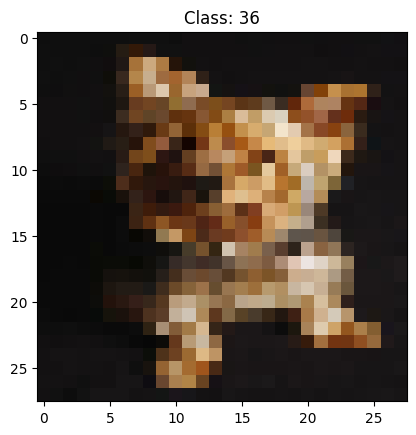

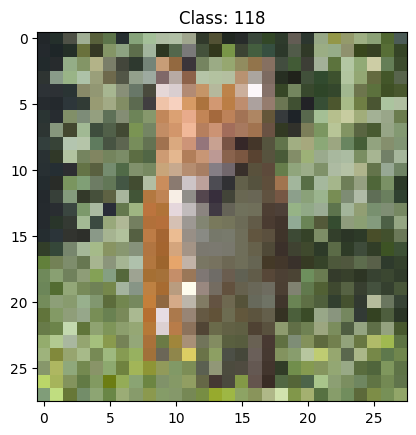

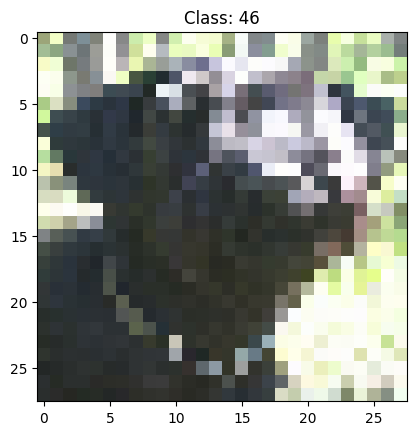

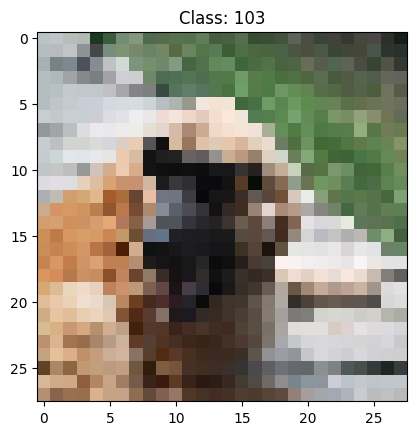

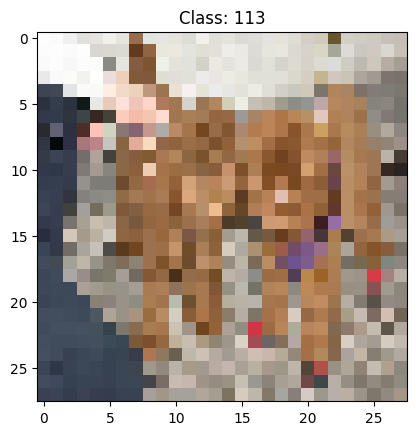

In [205]:
X_train, X_test, y_train, y_test = load_and_preprocess_dataset(12000, 8580)

In [206]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print('Min:', X_train.min())
print('Max:', X_train.max())

X_train: (12000, 2352)
y_train: (12000, 120)
X_test: (8580, 2352)
y_test: (8580, 120)
Min: -1.9982667623105923
Max: 2.5340386692272783


In [207]:
X_train = X_train.reshape(X_train.shape[0],28,28,3)
X_test = X_test.reshape(X_test.shape[0],28,28,3)

In [194]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [195]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/mikeredshaw/Documents/Schulich MBAN/Data Science II/Assignment 3 - Image Classification/best_model.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [196]:
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,3)),#we're dealing w colored images so we need 3 channels, we're using 32 filters, 3x3 size (shape), then pick activation function (ReLU), then can use soft_max at the end (standard practice w reLu)
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #don't have to specify input shape for 2nd layer, just first. This one can have bigger filter.
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #most models will have 3 to 8 convolution layers
    tf.keras.layers.Flatten(), #should have at least one dense layer in your model.
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax') #this needs to have 120 layers because we have 10 categories. Adding the softmax at the end as mentioned before
])

In [197]:
custom_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_99 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_100 (Conv2D)         (None, 3, 3, 128)         73856     
                                                                 
 flatten_26 (Flatten)        (None, 1152)            

In [198]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_history = custom_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping])

Epoch 1/50
188/188 [==============================] - 3s 15ms/step - loss: 4.6774 - accuracy: 0.0171 - val_loss: 4.5043 - val_accuracy: 0.0249
Epoch 2/50
188/188 [==============================] - 2s 13ms/step - loss: 4.4155 - accuracy: 0.0366 - val_loss: 4.3998 - val_accuracy: 0.0340
Epoch 3/50
188/188 [==============================] - 3s 14ms/step - loss: 4.2654 - accuracy: 0.0516 - val_loss: 4.3293 - val_accuracy: 0.0487
Epoch 4/50
188/188 [==============================] - 3s 14ms/step - loss: 4.1173 - accuracy: 0.0768 - val_loss: 4.2550 - val_accuracy: 0.0610
Epoch 5/50
188/188 [==============================] - 3s 14ms/step - loss: 3.9464 - accuracy: 0.0974 - val_loss: 4.2110 - val_accuracy: 0.0723
Epoch 6/50
188/188 [==============================] - 2s 13ms/step - loss: 3.7671 - accuracy: 0.1256 - val_loss: 4.2423 - val_accuracy: 0.0759
Epoch 7/50
188/188 [==============================] - 3s 14ms/step - loss: 3.5240 - accuracy: 0.1716 - val_loss: 4.3247 - val_accuracy: 0.0787

In [208]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])


In [200]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [201]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/50
188/188 [==============================] - 5s 24ms/step - loss: 4.6474 - accuracy: 0.0180 - val_loss: 4.5011 - val_accuracy: 0.0286
Epoch 2/50
188/188 [==============================] - 5s 24ms/step - loss: 4.3956 - accuracy: 0.0383 - val_loss: 4.4046 - val_accuracy: 0.0352
Epoch 3/50
188/188 [==============================] - 4s 23ms/step - loss: 4.2561 - accuracy: 0.0502 - val_loss: 4.3072 - val_accuracy: 0.0529
Epoch 4/50
188/188 [==============================] - 4s 23ms/step - loss: 4.0984 - accuracy: 0.0700 - val_loss: 4.1697 - val_accuracy: 0.0667
Epoch 5/50
188/188 [==============================] - 4s 22ms/step - loss: 3.9468 - accuracy: 0.0948 - val_loss: 4.1499 - val_accuracy: 0.0670
Epoch 6/50
188/188 [==============================] - 4s 23ms/step - loss: 3.7495 - accuracy: 0.1227 - val_loss: 4.1613 - val_accuracy: 0.0782
Epoch 7/50
188/188 [==============================] - 4s 23ms/step - loss: 3.5224 - accuracy: 0.1628 - val_loss: 4.2522 - val_accuracy: 0.0845

In [209]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [210]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [211]:
model_2_history = model_2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 3s 14ms/step - loss: 4.7636 - accuracy: 0.0112 - val_loss: 4.6993 - val_accuracy: 0.0231
Epoch 2/50
188/188 [==============================] - 3s 14ms/step - loss: 4.6108 - accuracy: 0.0213 - val_loss: 4.5246 - val_accuracy: 0.0269
Epoch 3/50
188/188 [==============================] - 3s 14ms/step - loss: 4.5008 - accuracy: 0.0277 - val_loss: 4.4246 - val_accuracy: 0.0382
Epoch 4/50
188/188 [==============================] - 3s 16ms/step - loss: 4.4316 - accuracy: 0.0335 - val_loss: 4.3506 - val_accuracy: 0.0437
Epoch 5/50
188/188 [==============================] - 3s 14ms/step - loss: 4.3549 - accuracy: 0.0408 - val_loss: 4.3204 - val_accuracy: 0.0502
Epoch 6/50
188/188 [==============================] - 3s 14ms/step - loss: 4.3086 - accuracy: 0.0449 - val_loss: 4.2691 - val_accuracy: 0.0559
Epoch 7/50
188/188 [==============================] - 3s 14ms/step - loss: 4.2426 - accuracy: 0.0546 - val_loss: 4.2131 - val_accuracy: 0.0593

In [212]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])


In [213]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [214]:
model_3_history = model_3.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 5s 26ms/step - loss: 4.7137 - accuracy: 0.0157 - val_loss: 4.5664 - val_accuracy: 0.0283
Epoch 2/50
188/188 [==============================] - 5s 26ms/step - loss: 4.4440 - accuracy: 0.0400 - val_loss: 4.4085 - val_accuracy: 0.0402
Epoch 3/50
188/188 [==============================] - 5s 25ms/step - loss: 4.2569 - accuracy: 0.0621 - val_loss: 4.2933 - val_accuracy: 0.0569
Epoch 4/50
188/188 [==============================] - 5s 25ms/step - loss: 4.0967 - accuracy: 0.0777 - val_loss: 4.2631 - val_accuracy: 0.0659
Epoch 5/50
188/188 [==============================] - 5s 25ms/step - loss: 3.9106 - accuracy: 0.1058 - val_loss: 4.2221 - val_accuracy: 0.0720
Epoch 6/50
188/188 [==============================] - 5s 25ms/step - loss: 3.6978 - accuracy: 0.1402 - val_loss: 4.2998 - val_accuracy: 0.0719
Epoch 7/50
188/188 [==============================] - 5s 25ms/step - loss: 3.4546 - accuracy: 0.1850 - val_loss: 4.3812 - val_accuracy: 0.0788

In [215]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [216]:
l2_regularization = 0.01

In [220]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [224]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [227]:
model_4_history = model_4.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 6s 28ms/step - loss: 4.6504 - accuracy: 0.0223 - val_loss: 4.5043 - val_accuracy: 0.0324
Epoch 2/50
188/188 [==============================] - 5s 26ms/step - loss: 4.3630 - accuracy: 0.0467 - val_loss: 4.3524 - val_accuracy: 0.0515
Epoch 3/50
188/188 [==============================] - 5s 25ms/step - loss: 4.1302 - accuracy: 0.0780 - val_loss: 4.2845 - val_accuracy: 0.0578
Epoch 4/50
188/188 [==============================] - 5s 25ms/step - loss: 3.8274 - accuracy: 0.1234 - val_loss: 4.2864 - val_accuracy: 0.0698
Epoch 5/50
188/188 [==============================] - 5s 26ms/step - loss: 3.3894 - accuracy: 0.2037 - val_loss: 4.5317 - val_accuracy: 0.0711
Epoch 6/50
188/188 [==============================] - 5s 25ms/step - loss: 2.7287 - accuracy: 0.3300 - val_loss: 5.0612 - val_accuracy: 0.0657
Epoch 7/50
188/188 [==============================] - 5s 25ms/step - loss: 1.8704 - accuracy: 0.5202 - val_loss: 5.9331 - val_accuracy: 0.0662

In [228]:
model_4.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [229]:
model_4_history = model_4.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 5s 25ms/step - loss: 3.7015 - accuracy: 0.1545 - val_loss: 4.3298 - val_accuracy: 0.0699
Epoch 2/50
188/188 [==============================] - 5s 25ms/step - loss: 3.5998 - accuracy: 0.1684 - val_loss: 4.3682 - val_accuracy: 0.0707
Epoch 3/50
188/188 [==============================] - 5s 25ms/step - loss: 3.5370 - accuracy: 0.1776 - val_loss: 4.3976 - val_accuracy: 0.0746
Epoch 4/50
188/188 [==============================] - 5s 25ms/step - loss: 3.4827 - accuracy: 0.1887 - val_loss: 4.4298 - val_accuracy: 0.0734
Epoch 5/50
188/188 [==============================] - 5s 24ms/step - loss: 3.4317 - accuracy: 0.1954 - val_loss: 4.4477 - val_accuracy: 0.0726
Epoch 6/50
188/188 [==============================] - 5s 24ms/step - loss: 3.3827 - accuracy: 0.2062 - val_loss: 4.4585 - val_accuracy: 0.0737


The best performing model, with all the variations, was model_1. I will look to evaluate this model further.

In [230]:
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

269/269 [==============================] - 1s 5ms/step - loss: 8.8524 - accuracy: 0.0802
Test Loss: 8.852392196655273
Test Accuracy: 0.08018647879362106


In [231]:
X_test_preprocessed = X_test.reshape(-1, 28, 28, 3)

y_pred = model_1.predict(X_test_preprocessed)

y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

confusion = confusion_matrix(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(confusion)


269/269 [==============================] - 1s 5ms/step
Confusion Matrix:
[[ 2  0  0 ...  0  0  1]
 [ 0 26  1 ...  0  0  0]
 [ 2  1 17 ...  1  0  0]
 ...
 [ 1  0  1 ...  4  4  0]
 [ 0  0  0 ...  6  6  0]
 [ 2  0  0 ...  3  0 11]]
